Dataset Shape: (55500, 15)


C:\Users\roshan\AppData\Local\Temp\ipykernel_20404\331298286.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Processed Dataset Shape: (55500, 12)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters Found: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

✅ Accuracy: 0.2872972972972973

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.28      0.28      1862
           1       0.28      0.28      0.28      1837
           2       0.29      0.28      0.29      1845
           3       0.28      0.28      0.28      1861
           4       0.30      0.31      0.30      1849
           5       0.30      0.30      0.30      1846

    accuracy                           0.29     11100
   macro avg       0.29      0.29      0.29     11100
weighted avg       0.29      0.29      0.29     11100



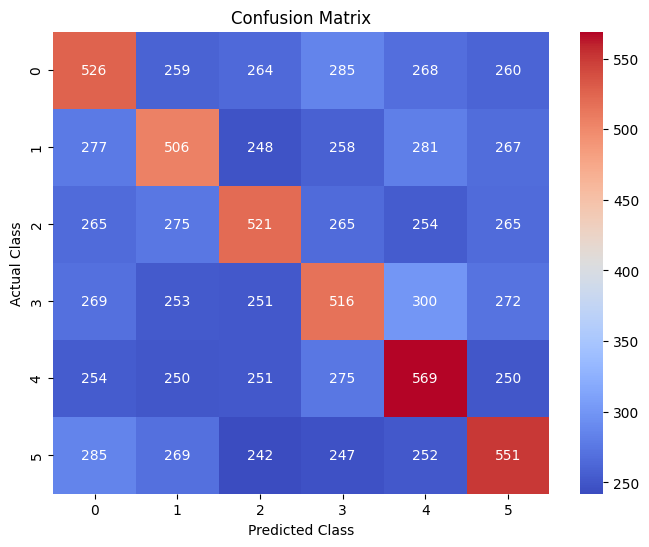

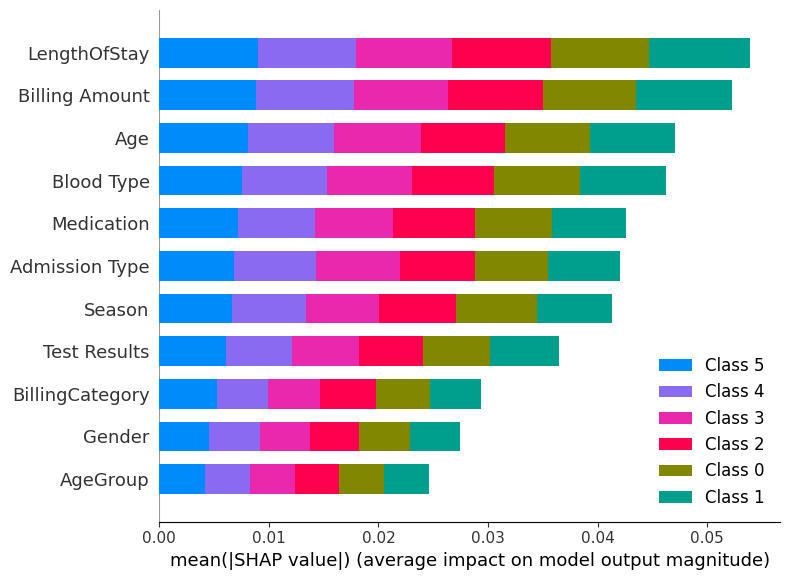

C:\Users\roshan\AppData\Local\Temp\ipykernel_20404\331298286.py:117: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_billing.fillna(method='ffill', inplace=True)
C:\Users\roshan\AppData\Local\Temp\ipykernel_20404\331298286.py:133: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(billing_per_month.index[-1] + pd.DateOffset(months=1), periods=12, freq='M'), forecast, label='Forecast', color='red')


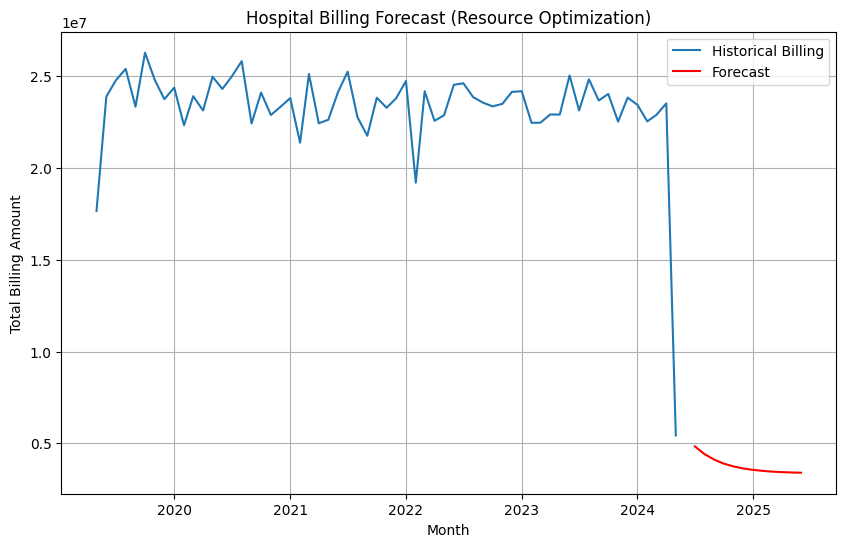

In [1]:
# Install necessary libraries
    
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
file_path = 'healthcare_ds.csv'
df = pd.read_csv(file_path)

# Initial exploration
print(f"Dataset Shape: {df.shape}")
df.head()

# Drop irrelevant columns
drop_cols = ['Name', 'Doctor', 'Room Number', 'Insurance Provider', 'Hospital']
df.drop(columns=drop_cols, inplace=True)

# Handle missing values
df.fillna(method='ffill', inplace=True)

# Feature Engineering
# Age Groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

# Billing Category
df['BillingCategory'] = pd.cut(df['Billing Amount'], bins=[0, 5000, 15000, 30000, 50000, 100000], labels=['Low', 'Medium', 'High', 'Very High', 'Extreme'])

# Length of Stay
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
df['LengthOfStay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# Season of Admission
df['AdmissionMonth'] = df['Date of Admission'].dt.month
df['Season'] = df['AdmissionMonth'].apply(lambda x: ('Winter' if x in [12, 1, 2] else
                                                     'Spring' if x in [3, 4, 5] else
                                                     'Summer' if x in [6, 7, 8] else 'Fall'))

# Encode categorical columns
categorical_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type',
                    'AgeGroup', 'BillingCategory', 'Season', 'Medication', 'Test Results']

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Drop unnecessary columns
df.drop(columns=['Date of Admission', 'Discharge Date', 'AdmissionMonth'], inplace=True)

# Final Data Shape
print(f"Processed Dataset Shape: {df.shape}")
df.head()

# Define Features and Target
X = df.drop('Medical Condition', axis=1)
y = df['Medical Condition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters Found:", grid_search.best_params_)

# Predict
y_pred = best_rf.predict(X_test_scaled)

# Evaluation
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm")
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Feature Importance using SHAP
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP Summary
shap.summary_plot(shap_values, X_test, plot_type="bar")

# ---- Resource Optimization using ARIMA ----
# Reload dataset for Billing Trend (with dates)
df_billing = pd.read_csv(file_path)
df_billing['Date of Admission'] = pd.to_datetime(df_billing['Date of Admission'])
df_billing.fillna(method='ffill', inplace=True)

# Aggregate Billing Amount by Month
billing_per_month = df_billing.groupby(df_billing['Date of Admission'].dt.to_period('M'))['Billing Amount'].sum()
billing_per_month.index = billing_per_month.index.to_timestamp()

# Train ARIMA model
model = ARIMA(billing_per_month, order=(1,1,1))
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)

# Plot Billing Trend Forecast
plt.figure(figsize=(10,6))
plt.plot(billing_per_month, label='Historical Billing')
plt.plot(pd.date_range(billing_per_month.index[-1] + pd.DateOffset(months=1), periods=12, freq='M'), forecast, label='Forecast', color='red')
plt.title('Hospital Billing Forecast (Resource Optimization)')
plt.xlabel('Month')
plt.ylabel('Total Billing Amount')
plt.legend()
plt.grid(True)
plt.show()
